In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
cnxn = create_engine('sqlite:///vn.db')

In [6]:
query = "SELECT * FROM HSX WHERE ticker = 'VNM' ORDER BY date"

In [7]:
df = pd.read_sql(query, cnxn, parse_dates=['date'])

In [8]:
df.tail()

,ticker,date,open,high,low,close,volume
1784,VNM,2020-08-13,116.0,116.6,115.9,116.4,1238980
1785,VNM,2020-08-17,117.0,117.9,115.3,117.0,906890
1786,VNM,2020-08-18,117.0,117.4,115.6,115.6,604570
1787,VNM,2020-08-19,116.0,116.0,114.9,115.3,981840
1788,VNM,2020-08-20,115.3,115.8,114.6,115.2,1254280


In [9]:
df['mid'] = (df['high'] + df['low']) / 2

In [10]:
train_set = df[['mid']].iloc[:-40,:]
test_set = df[['mid']].iloc[-40:,:]

In [11]:
day_to_window = 30

In [12]:
sc = MinMaxScaler(feature_range=(0,1))
stage_train = sc.fit_transform(train_set.values.reshape(-1,1))
X_train = []
y_train = []
for i in range(day_to_window, len(stage_train)):
    X_train.append(stage_train[i-day_to_window:i, :])
    y_train.append(stage_train[i, :])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [13]:
dataset_total = pd.concat((train_set, test_set), axis = 0)
inputs = dataset_total[len(df) - len(test_set) - day_to_window:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
y_test = []
for i in range(day_to_window, day_to_window + len(test_set)):
    X_test.append(inputs[i-day_to_window:i, :])
    y_test.append(inputs[i, :])
X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [14]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1, activation='relu'))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

nn = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 200, batch_size = 32)

 0.0116
Epoch 86/200
54/54 [==============================] - 2s 28ms/step - loss: 7.9279e-04 - mean_absolute_error: 0.0193 - val_loss: 5.3901e-04 - val_mean_absolute_error: 0.0214
Epoch 87/200
54/54 [==============================] - 1s 28ms/step - loss: 7.6424e-04 - mean_absolute_error: 0.0188 - val_loss: 1.8690e-04 - val_mean_absolute_error: 0.0100
Epoch 88/200
54/54 [==============================] - 1s 28ms/step - loss: 9.0277e-04 - mean_absolute_error: 0.0199 - val_loss: 3.3966e-04 - val_mean_absolute_error: 0.0160
Epoch 89/200
54/54 [==============================] - 1s 28ms/step - loss: 8.3671e-04 - mean_absolute_error: 0.0196 - val_loss: 5.5335e-04 - val_mean_absolute_error: 0.0194
Epoch 90/200
54/54 [==============================] - 2s 28ms/step - loss: 8.7397e-04 - mean_absolute_error: 0.0203 - val_loss: 2.6878e-04 - val_mean_absolute_error: 0.0115
Epoch 91/200
54/54 [==============================] - 2s 28ms/step - loss: 8.8838e-04 - mean_absolute_error: 0.0198 - val_loss:

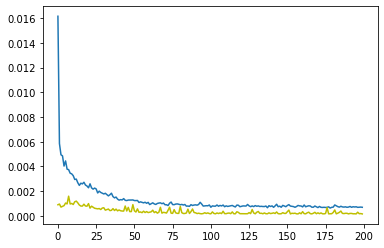

In [15]:
fig, ax = plt.subplots()
ax.plot(nn.history['loss'])
ax.plot(nn.history['val_loss'], color='y')

In [16]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [17]:
real = test_set.values

In [18]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        name='real',
        x=df.iloc[-40:,:]['date'],
        y=real.flatten()
    )
)

fig.add_trace(
    go.Scatter(
        name='pred',
        x=df.iloc[-40:,:]['date'],
        y=predicted_stock_price.flatten()
    )
)
fig.show()

In [40]:
mean_squared_error(real, predicted_stock_price)

5.409361499134738

In [ ]:
0.08086984669252982